In [2]:
import xarray as xr
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

from scipy import signal
from scipy import stats

import utils

# Ocean Uptake Efficiency (%)

Here we calculate ocean uptake efficiency. Values of 100% indicate the ocean is taking about half of fossil fuel emissions. Lower efficiency means lower uptake, more CO2 in the atmosphere, and thus more global warming 

In [3]:
# processed model data
ds_cant = xr.open_dataset('../lens_cant_flux_box_plot.nc')
ds_cant = utils.fix_cesm_time(ds_cant).groupby('time.year').sum(dim='time')

In [4]:
atm_co2_hist = xr.open_dataset(f'../4.5 vs 8.5/ATM_CO2_HIST.nc')
atm_co2_proj = xr.open_dataset(f'../4.5 vs 8.5/ATM_CO2_RCP85.nc')

atm_co2 = xr.concat((atm_co2_hist['ATM_CO2'],atm_co2_proj['ATM_CO2']),dim='year')

Calculate Efficiency

In [8]:
# 1920 is a better reference year than 1990
# 1920 selected by optimizing for 100% efficiency
f_ref = ds_cant.total_median.sel(year=1920)
f_exp = f_ref*(atm_co2-280)/(atm_co2.sel(year=1920)-280)

In [9]:
eff = ds_cant.sel(year=slice(1920,2080))/f_exp.sel(year=slice(1920,2080))
eff = eff*100 # units of percent

Plot Uptake Efficiency

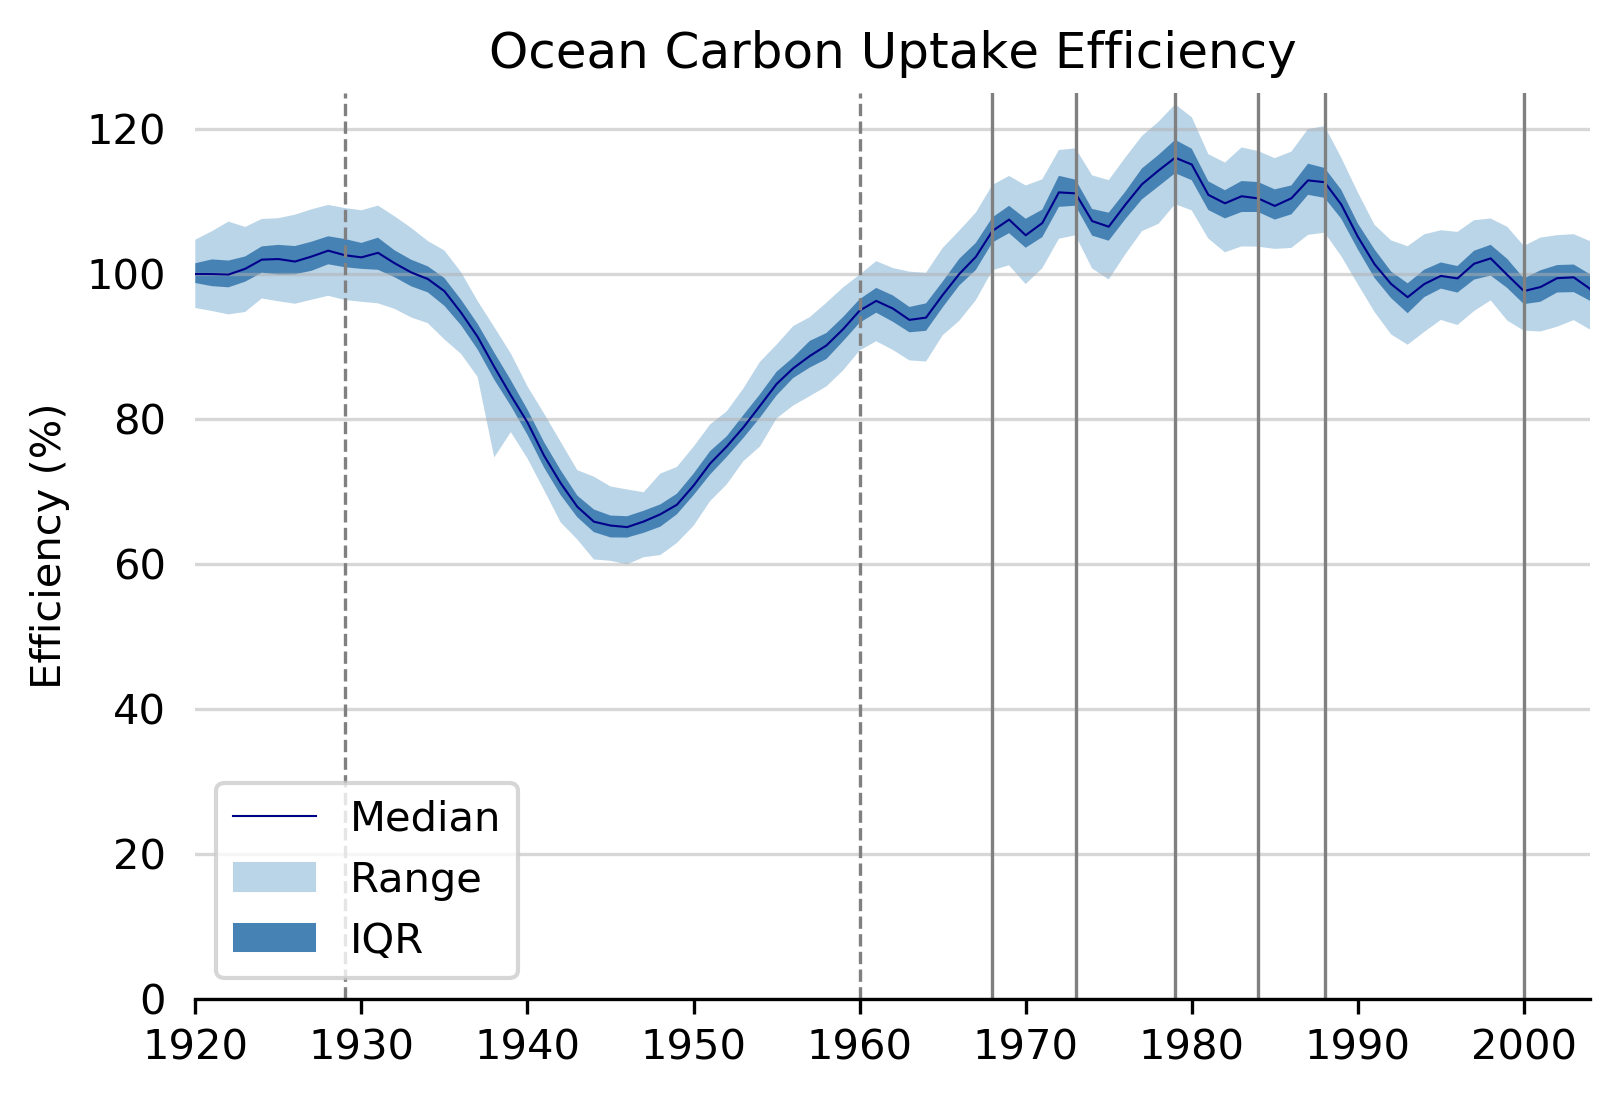

In [12]:
plt.figure(dpi=300)

plt.fill_between(eff.year,eff.total_min,eff.total_max,
                 alpha=0.3,color='tab:blue',linewidth=0.01, label='Range')
plt.fill_between(eff.year,eff.total_q1,eff.total_q3,
                 color='steelblue',linewidth=0.01, label='IQR')

plt.plot(eff.year,eff.total_median,
         linewidth=0.5,color='darkblue',label='Median')

kwargs1={'color':'0.5','linewidth':0.8,'linestyle':'--'}
kwargs2={'color':'0.5','linewidth':0.8}

plt.axvline(1929,**kwargs1)
plt.axvline(1960,**kwargs1)
plt.axvline(1968,**kwargs2)
plt.axvline(1973,**kwargs2)
plt.axvline(1979,**kwargs2)
plt.axvline(1984,**kwargs2)
plt.axvline(1988,**kwargs2)
plt.axvline(2000,**kwargs2)

plt.ylim(0,125)
plt.xlim(1920,2004)
plt.ylabel('Efficiency (%)')
plt.title('Ocean Carbon Uptake Efficiency')

utils.time_series(ax=plt.gca())
plt.legend()

# Download Data

In [7]:
# !wget "http://api.worldbank.org/v2/en/indicator/NY.GDP.MKTP.KD.ZG?downloadformat=csv" -O GDP_growth.zip
# !unzip -o GDP_growth.zip

In [8]:
# !wget "ftp://aftp.cmdl.noaa.gov/products/trends/co2/co2_gr_mlo.txt"

In [9]:
# !wget "http://cdiac.ess-dive.lbl.gov/ftp/ndp030/CSV-FILES/global.1751_2014.csv"

# Economic Growth Rate

In [10]:
df = pd.read_csv('./API_NY.GDP.MKTP.KD.ZG_DS2_en_csv_v2_887216.csv',skiprows=3)
df.loc[df['Country Code']=='HIC']

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,Unnamed: 64
93,High income,HIC,GDP growth (annual %),NY.GDP.MKTP.KD.ZG,NaN,4.721187,5.879033,5.469251,6.538147,5.508662,...,1.858678,1.281769,1.439832,2.026102,2.330356,1.713476,2.302777,2.237871,NaN,NaN


In [11]:
df = df.drop(columns=['Country Name','Country Code','Indicator Name','Indicator Code'])
df.loc[93].index

Index(['1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968',
       '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977',
       '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986',
       '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995',
       '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004',
       '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013',
       '2014', '2015', '2016', '2017', '2018', '2019', 'Unnamed: 64'],
      dtype='object')

In [12]:
df.loc[93].head()

1960         NaN
1961    4.721187
1962    5.879033
1963    5.469251
1964    6.538147
Name: 93, dtype: float64

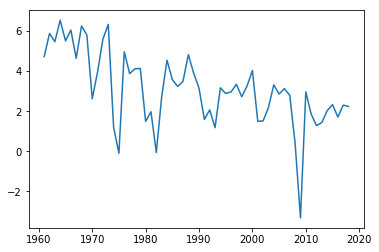

In [13]:
HIC_gdp_growth = df.loc[93].drop('Unnamed: 64')
HIC_gdp_growth.index = HIC_gdp_growth.index.astype(int)
HIC_gdp_growth.plot()

# Emission Growth Rate

In [14]:
emissions = pd.read_csv('./Emissions.txt',sep='\t')
emissions = emissions.set_index('Year')
emissions.head()

,FF,LUC
Year,,
1959,2.42,1.81
1960,2.55,1.65
1961,2.56,1.57
1962,2.65,1.53
1963,2.80,1.47


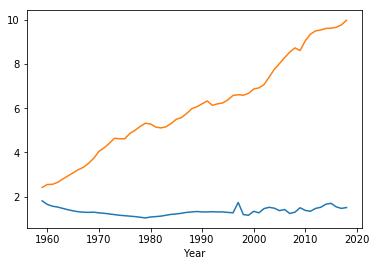

In [15]:
emissions['LUC'].plot()
emissions['FF'].plot()

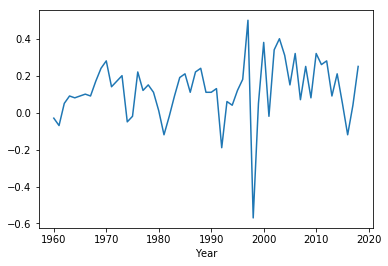

In [16]:
emissions['LUC growth'] = emissions['LUC'].diff()
emissions['FF growth'] = emissions['FF'].diff()
emissions['emiss. growth'] = (emissions['FF'] + emissions['LUC']).diff()
emissions['emiss. growth'].plot()

# CO2 Growth Rate

/home/sridge/.conda/envs/analysis/lib/python3.6/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


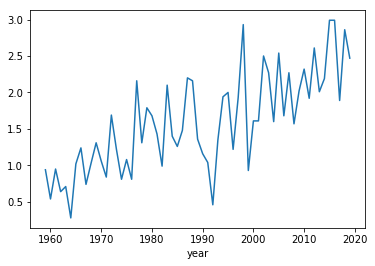

In [17]:
CO2_growth = pd.read_csv('./co2_gr_mlo.txt',sep='     ',skiprows=59)
CO2_growth = CO2_growth.rename(columns={'   growth':'CO2 growth','   unc':'unc'})
CO2_growth = CO2_growth.drop(columns = 'unc')
CO2_growth = CO2_growth.set_index('year')
CO2_growth['CO2 growth'].plot()

# Detrend Timeseries 

In [18]:
df = pd.concat([CO2_growth, HIC_gdp_growth,emissions['emiss. growth']], axis=1)
df = df.rename(columns={93:'HIC GDP growth'})
df = df.dropna()

In [19]:
slope, intercept, r_value, p_value, std_err = stats.linregress(df.index.values,df['HIC GDP growth'].values)
gdp_trendline = slope*df.index.values+intercept

In [20]:
slope, intercept, r_value, p_value, std_err = stats.linregress(df.index.values,df['CO2 growth'].values)
co2_trendline = slope*df.index.values+intercept

In [21]:
df['CO2 trend'] = co2_trendline
df['GDP trend'] = gdp_trendline

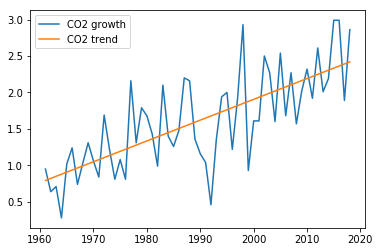

In [22]:
df[['CO2 growth','CO2 trend']].plot()

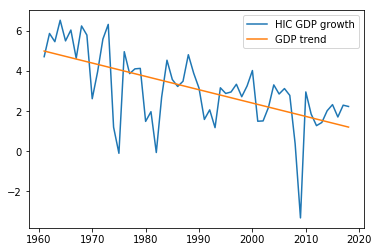

In [23]:
df[['HIC GDP growth','GDP trend']].plot()

In [24]:
df['GDP anom'] = df['HIC GDP growth'] - df['GDP trend']
df['CO2 anom'] = df['CO2 growth'] - df['CO2 trend']

# Smoothing

In [25]:
window_size = 3

In [26]:
df['GDP anom, smoothed'] = signal.savgol_filter(df['GDP anom'],window_size,1)

/home/sridge/.conda/envs/analysis/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


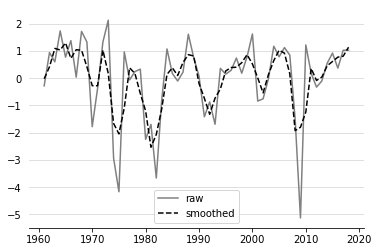

In [27]:
plt.plot(df.index,df['GDP anom'],color='0.5',label='raw')
plt.plot(df.index,df['GDP anom, smoothed'],color='k',linestyle='--',label='smoothed')
plt.legend()
utils.time_series(ax = plt.gca())

In [28]:
df['CO2 anom, smoothed'] = signal.savgol_filter(df['CO2 anom'],window_size,1)

/home/sridge/.conda/envs/analysis/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


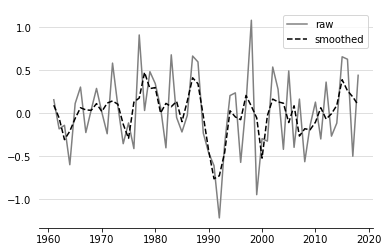

In [29]:
plt.plot(df.index,df['CO2 anom'],color='0.5',label='raw')
plt.plot(df.index,df['CO2 anom, smoothed'],color='k',linestyle='--',label='smoothed')
plt.legend()
utils.time_series(ax = plt.gca())

In [30]:
df['emiss. growth, smoothed'] = signal.savgol_filter(df['emiss. growth'],window_size,1)

/home/sridge/.conda/envs/analysis/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


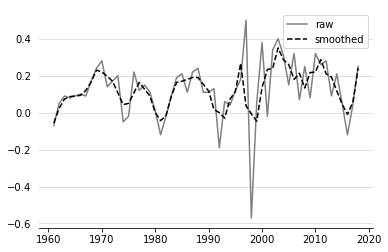

In [31]:
plt.plot(df.index,df['emiss. growth'],color='0.5',label='raw')
plt.plot(df.index,df['emiss. growth, smoothed'],color='k',linestyle='--',label='smoothed')
plt.legend()
utils.time_series(ax = plt.gca())

# **Effect of smoothing on correlation**


(<matplotlib.axes._subplots.AxesSubplot at 0x7f6e484f0390>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f6e4843b550>)

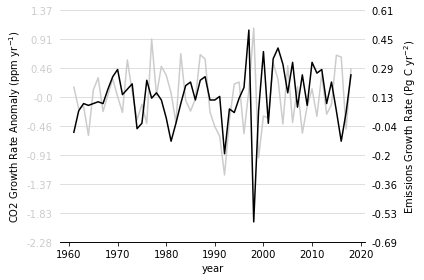

In [32]:
utils.twinx(df.index,df['CO2 anom'],df['emiss. growth'],
      xlabel='year',y1label='CO2 Growth Rate Anomaly (ppm yr$^{-1}$)',y2label='Emissions Growth Rate (Pg C yr$^{-2}$)',
      color1='0.8',color2='k')

In [33]:
stats.pearsonr(df['CO2 anom'],df['emiss. growth'])

(-0.04683157302716165, 0.7270245568407401)

(<matplotlib.axes._subplots.AxesSubplot at 0x7f6e483d8a90>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f6e48352d68>)

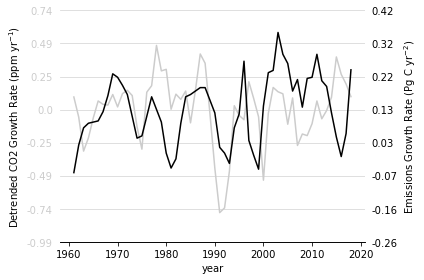

In [34]:
utils.twinx(df.index,df['CO2 anom, smoothed'],df['emiss. growth, smoothed'],
      xlabel='year',y1label='Detrended CO2 Growth Rate (ppm yr$^{-1}$)', y2label='Emissions Growth Rate (Pg C yr$^{-2}$)',
      color1='0.8',color2='k')

In [35]:
stats.pearsonr(df['CO2 anom, smoothed'],df['emiss. growth, smoothed'])

(0.15888771556827444, 0.23353701875653662)

# Ocean Model Data

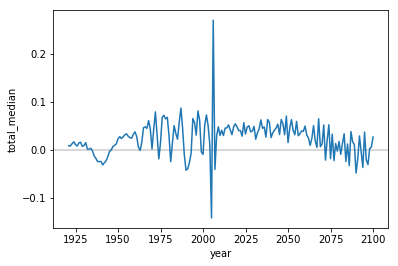

In [36]:
diff_flux = ds_cant.total_median.diff(dim='year')
plt.axhline(0,color='0.8')
diff_flux.plot()

(1961, 2003.9)

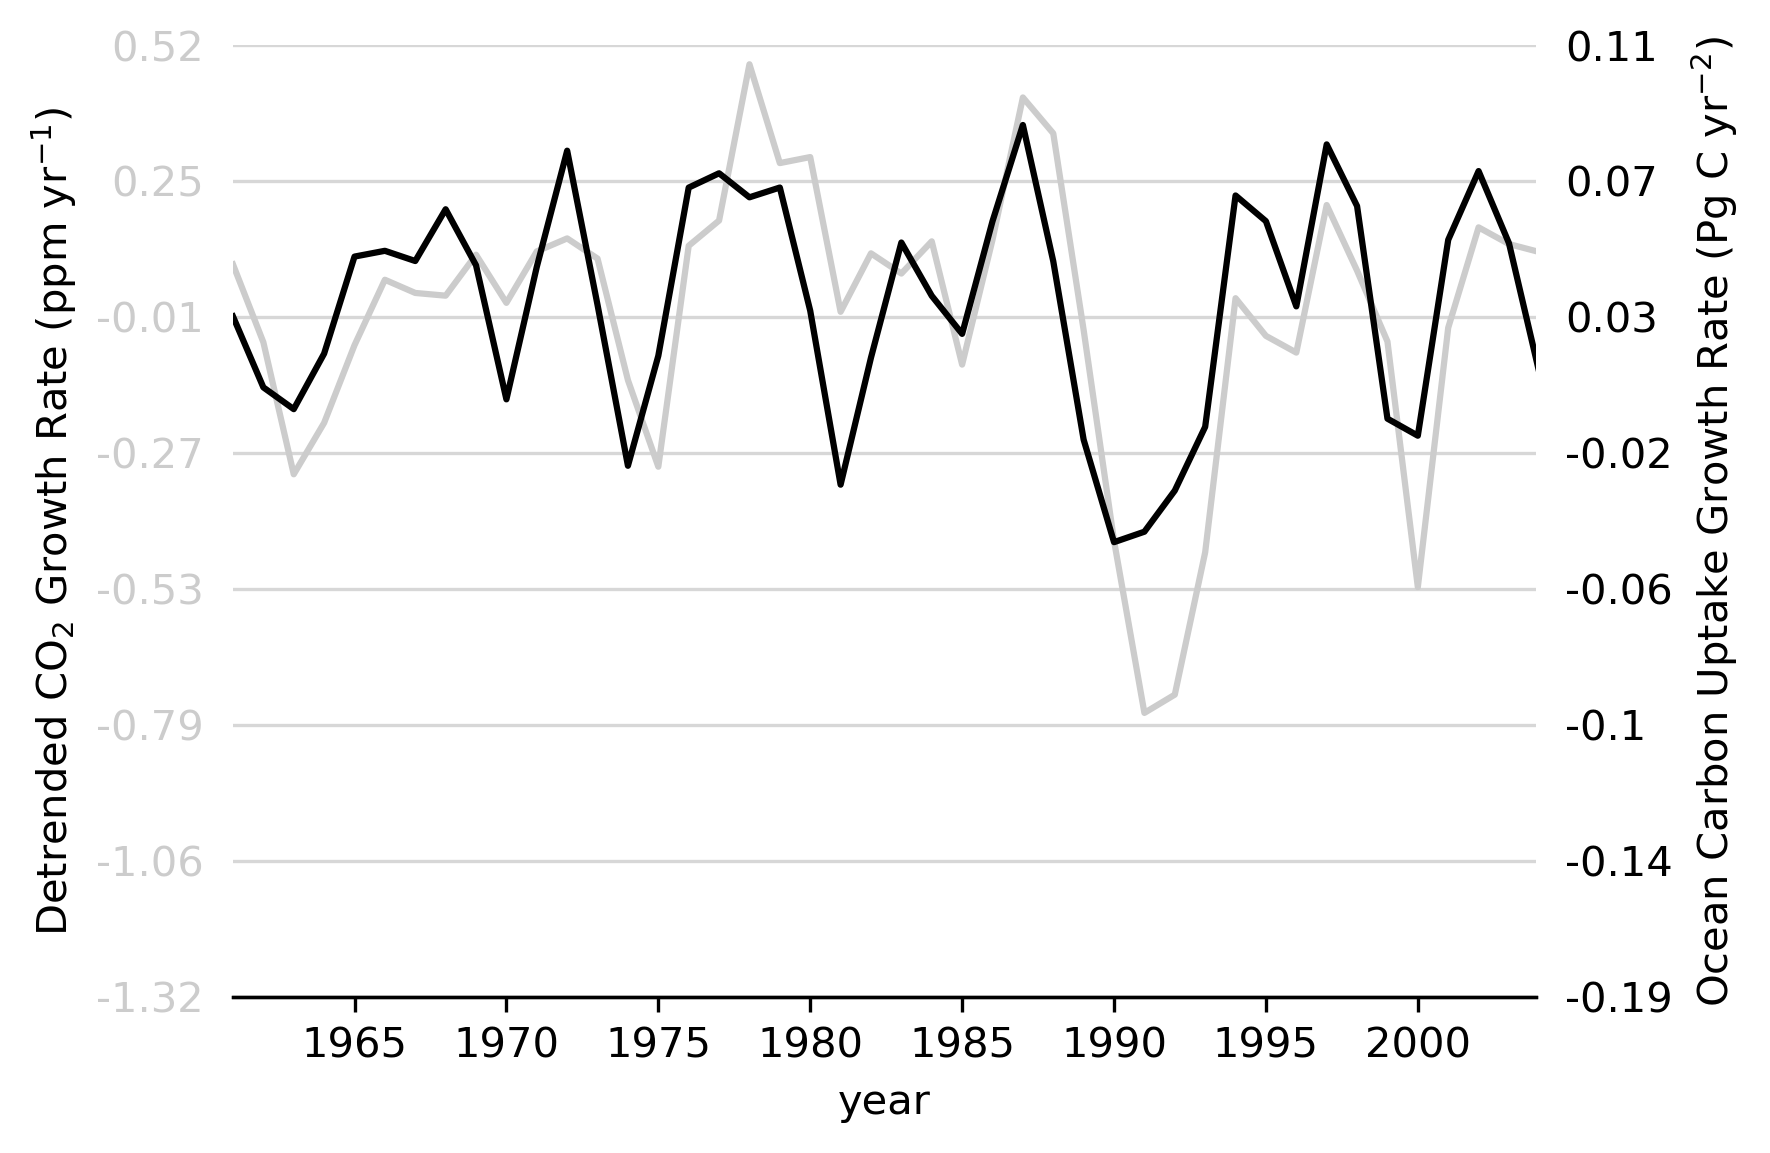

In [58]:
utils.twinx(df.loc[1961:2005].index,df['CO2 anom, smoothed'].loc[1961:2005],diff_flux.sel(year=df.loc[1961:2005].index).values,
      xlabel='year',
      y1label='Detrended CO$_2$ Growth Rate (ppm yr$^{-1}$)',
      y2label='Ocean Carbon Uptake Growth Rate (Pg C yr$^{-2}$)',
      color1='0.8',color2='k',dpi=300)

plt.xlim(1961,2003.9)

(1961, 2003.9)

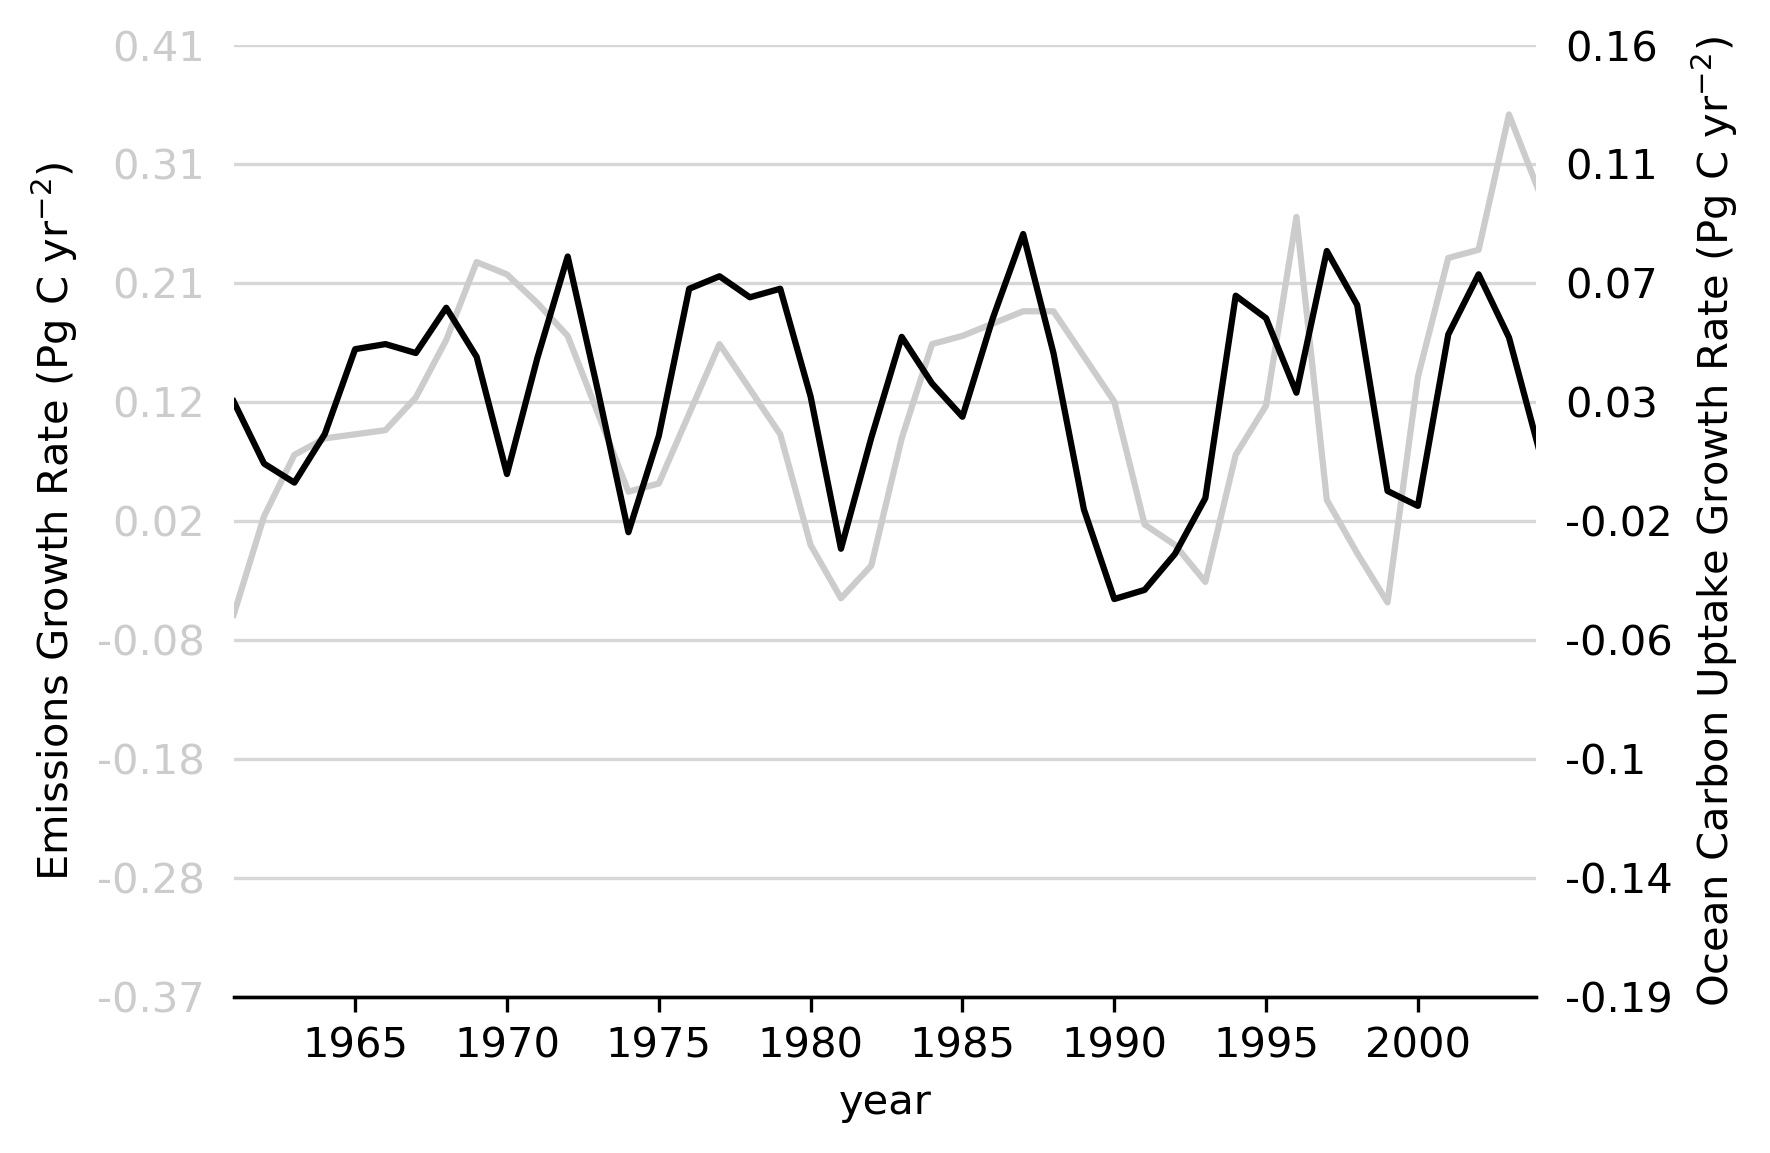

In [60]:
utils.twinx(df.loc[1961:2005].index,df['emiss. growth, smoothed'].loc[1961:2005],diff_flux.sel(year=df.loc[1961:2005].index).values,
      xlabel='year',
      y1label='Emissions Growth Rate (Pg C yr$^{-2}$)',
      y2label='Ocean Carbon Uptake Growth Rate (Pg C yr$^{-2}$)',
      color1='0.8',color2='k',dpi=300)
plt.xlim(1961,2003.9)

(1961, 2003.9)

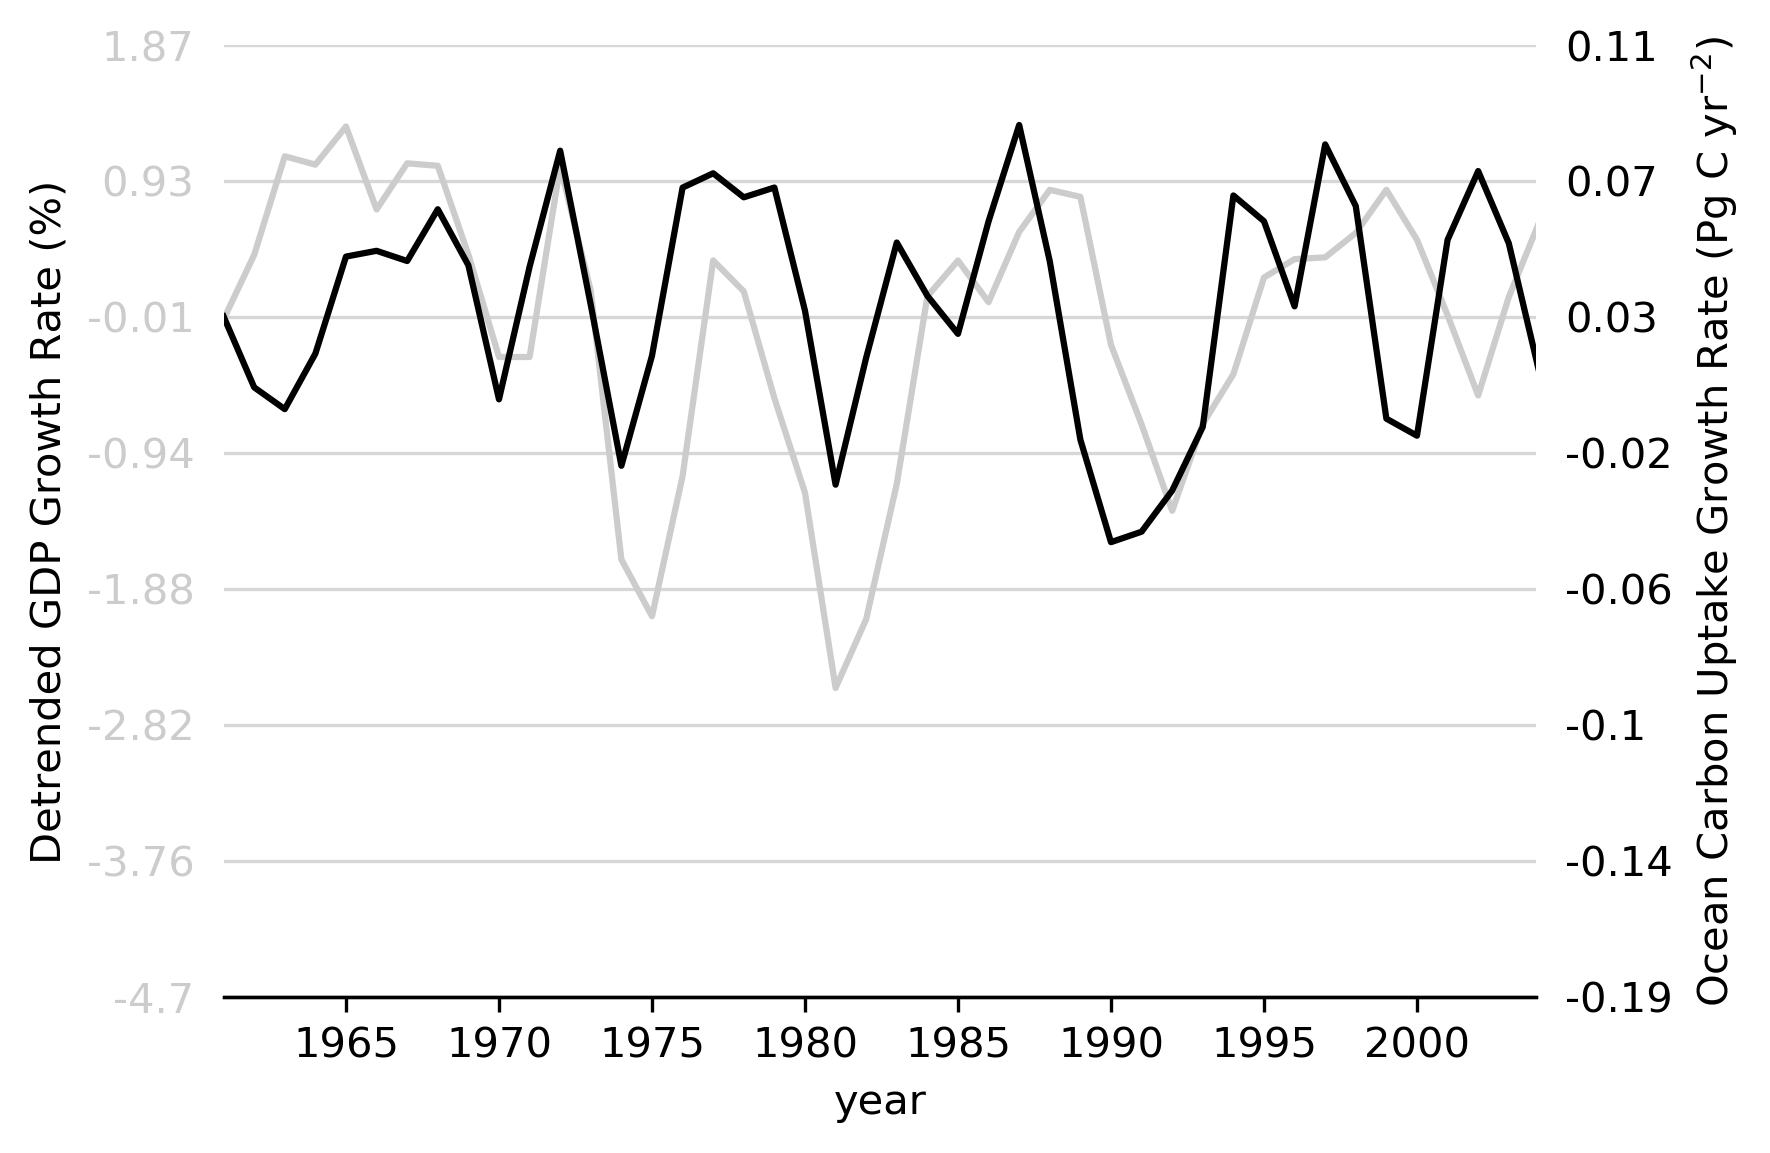

In [59]:
utils.twinx(df.loc[1961:2005].index,df['GDP anom, smoothed'].loc[1961:2005],diff_flux.sel(year=df.loc[1961:2005].index).values,
      xlabel='year',y1label='Detrended GDP Growth Rate (%)',y2label='Ocean Carbon Uptake Growth Rate (Pg C yr$^{-2}$)',
      color1='0.8',color2='k',dpi=300)
plt.xlim(1961,2003.9)

In [40]:
stats.pearsonr(df['CO2 anom, smoothed'].loc[1961:2005],diff_flux.sel(year=df.loc[1961:2005].index))

(0.6316783256097303, 3.2672938286698693e-06)

In [41]:
stats.pearsonr(df['GDP anom, smoothed'].loc[1960:1995],diff_flux.sel(year=df.loc[1960:1995].index))

(0.39179231028866285, 0.019932365601642188)

In [42]:
stats.pearsonr(df['emiss. growth, smoothed'].loc[1960:1995], df['GDP anom, smoothed'].loc[1960:1995])

(0.5763125260500349, 0.0002909727600656489)

In [43]:
stats.pearsonr(df['GDP anom, smoothed'].loc[1960:1995], df['CO2 anom, smoothed'].loc[1960:1995])

(0.20967647434638306, 0.22669872661666815)

# **Where is uptake growth rate correlated with GDP?**

# load the data

In [44]:
ddir = '/local/data/artemis/workspace/sridge/'

In [45]:
ds = xr.open_dataset(f'{ddir}FG.ensmean.192001-200512.nc')
ds = utils.fix_cesm_time(ds)

In [46]:
ds['FG_ANT'] = ds['FG_CO2']-ds['FG_ALT_CO2']

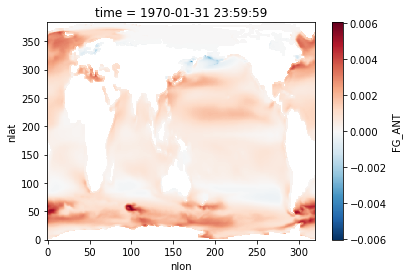

In [47]:
ds['FG_ANT'].isel(time=600).plot()

In [48]:
fg_ant = ds['FG_ANT'].groupby('time.year').mean(dim='time').load()

/home/sridge/.conda/envs/analysis/lib/python3.6/site-packages/xarray-0.14.1+10.g7dfdfca-py3.6.egg/xarray/core/common.py:664: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, the dimension order of these coordinates will be restored as well unless you specify restore_coord_dims=False.
  self, group, squeeze=squeeze, restore_coord_dims=restore_coord_dims
/home/sridge/.conda/envs/analysis/lib/python3.6/site-packages/xarray-0.14.1+10.g7dfdfca-py3.6.egg/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [49]:
econ = df['GDP anom, smoothed'].loc[1960:1995]
econ = econ.to_xarray()
econ = econ.rename({'index':'year'})
econ

<xarray.DataArray 'GDP anom, smoothed' (year: 35)>
array([-0.02007   ,  0.42049805,  1.09268741,  1.03576601,  1.29578467,
        0.72987669,  1.04478571,  1.02781052,  0.42217306, -0.27619962,
       -0.27640644,  1.02572139,  0.174842  , -1.65739152, -2.04456256,
       -1.08832165,  0.38194156,  0.17099661, -0.5565042 , -1.20210773,
       -2.53393084, -2.06434575, -1.14200747,  0.13748118,  0.38165464,
        0.09793   ,  0.57700759,  0.86400694,  0.81596705, -0.1934429 ,
       -0.73623503, -1.32567422, -0.7329679 , -0.39367986,  0.26583018])
Coordinates:
  * year     (year) int64 1961 1962 1963 1964 1965 ... 1991 1992 1993 1994 1995

In [50]:
fg_ant = fg_ant.sel(year=econ.year)
fg_ant_gr = fg_ant.diff(dim='year')
fg_ant.year

<xarray.DataArray 'year' (year: 35)>
array([1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972,
       1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984,
       1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995])
Coordinates:
  * year     (year) int64 1961 1962 1963 1964 1965 ... 1991 1992 1993 1994 1995

## Calculate Correlation Map

In [51]:
x,y = xr.broadcast(econ,fg_ant)

In [52]:
def corr2d(x,y,tdim):
    
    # Compute data length, mean and standard deviation along time axis: 
    n = len(x[tdim])
    xmean = x.mean(dim=tdim)
    ymean = y.mean(dim=tdim)
    xstd  = x.std(dim=tdim)
    ystd  = y.std(dim=tdim)

    # Compute covariance along time axis
    cov   =  ((x - xmean)*(y - ymean)).sum(dim=tdim)/(n)

    # Compute correlation along time axis
    cor   = cov/(xstd*ystd)
    
    return cor

In [53]:
import cmocean #perceptually uniform colorbars

# Visualize Correlation Map

/home/sridge/.conda/envs/analysis/lib/python3.6/site-packages/xarray-0.14.1+10.g7dfdfca-py3.6.egg/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Text(0.5,1,'GDP Growth Rate vs Uptake Growth Rate')

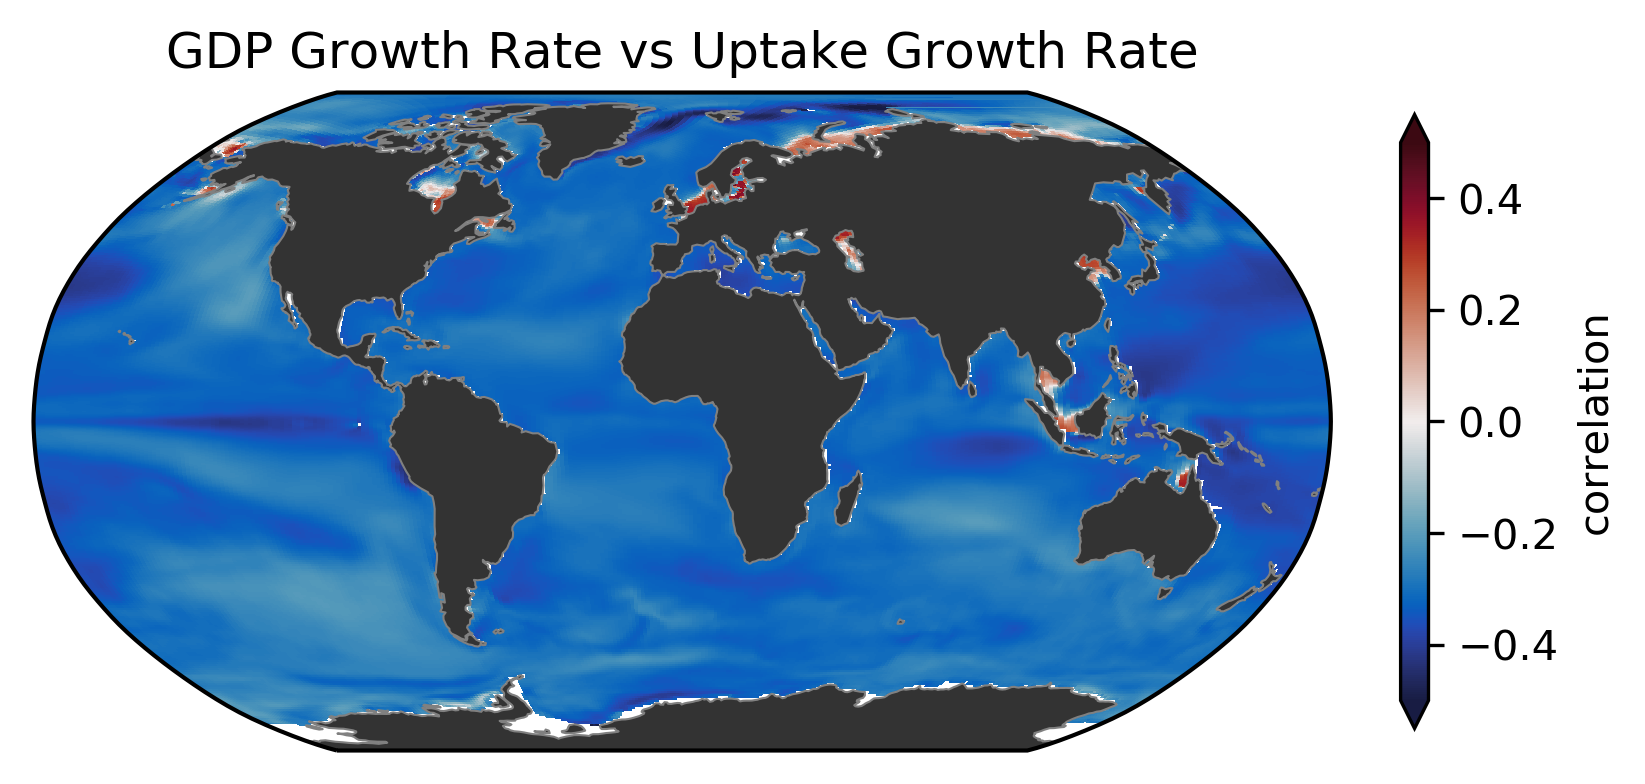

In [54]:
ax,cax = utils.plot_global(ds.TLONG,ds.TLAT,corr2d(x,y,'year'),
                           vmin=-0.5,vmax=0.5,
                           cmap=cmocean.cm.balance
                          )
plt.colorbar(cax,fraction=0.02,extend='both',label='correlation')
plt.title('GDP Growth Rate vs Uptake Growth Rate')

/home/sridge/.conda/envs/analysis/lib/python3.6/site-packages/xarray-0.14.1+10.g7dfdfca-py3.6.egg/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Text(0.5,1,'GDP Growth Rate vs Uptake Growth Rate')

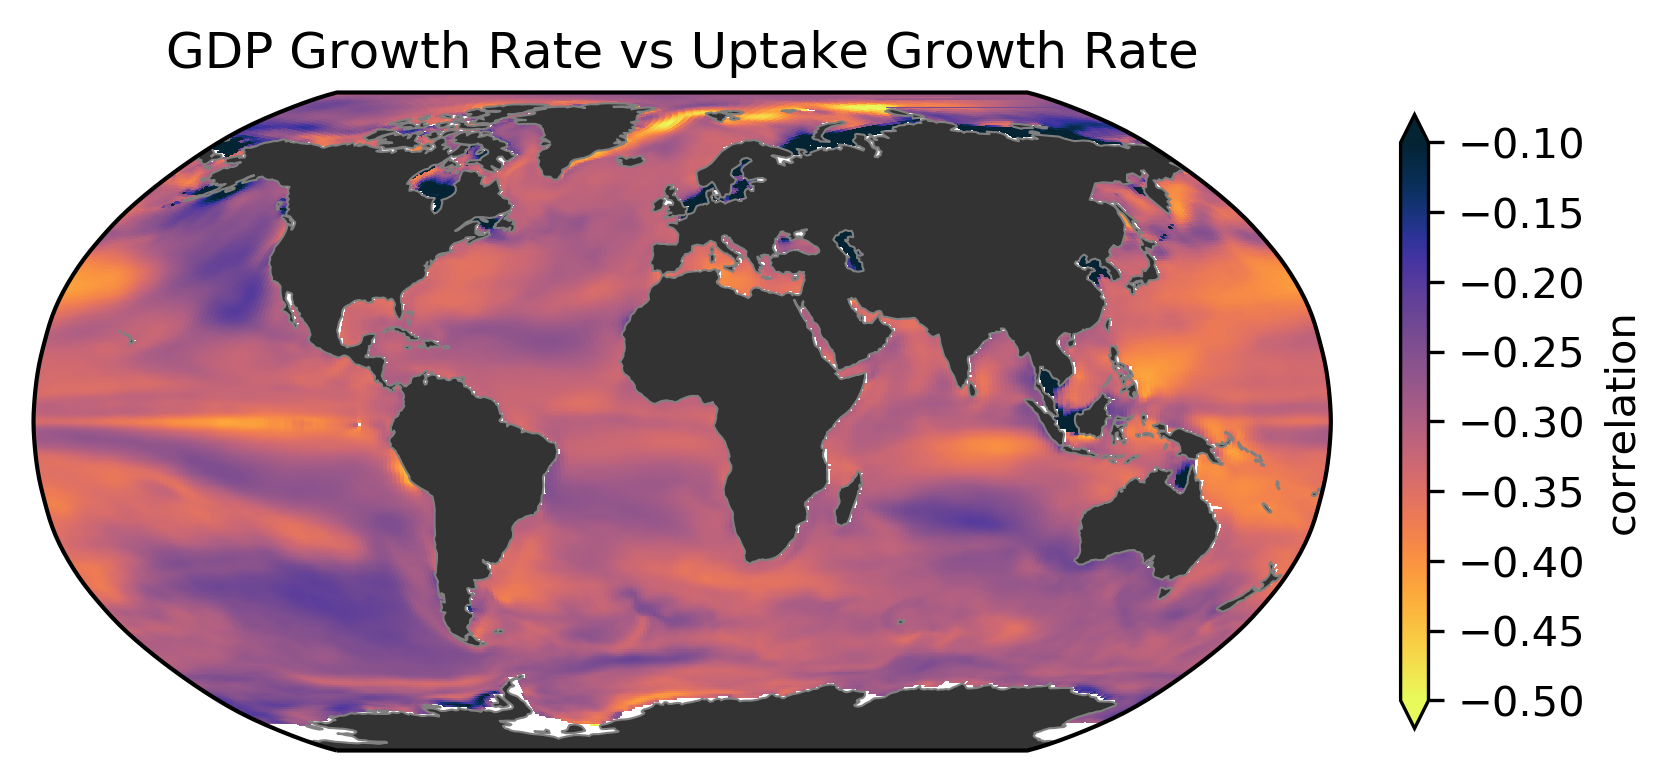

In [55]:
ax,cax = utils.plot_global(ds.TLONG,ds.TLAT,corr2d(x,y,'year'),
                           vmin=-0.5,vmax=-0.1,
                           cmap=cmocean.cm.thermal_r
                          )
plt.colorbar(cax,fraction=0.02,extend='both',label='correlation')
plt.title('GDP Growth Rate vs Uptake Growth Rate')